In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datalab_utils
import astropy.units as u

from dl import authClient as ac, queryClient as qc
from collections import Counter
from tqdm import tqdm

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = "/dlusers/adriansh/work/analyses/plots/strings/"

In [2]:
lc_df = pd.concat([pd.read_parquet(f"/dlusers/adriansh/work/analyses/results/strings/june12_2024/lightcurves_batch{i}.parquet") for i in range(10)])
time_df = pd.concat([pd.read_parquet(f"/dlusers/adriansh/work/analyses/results/strings/june12_2024/times_batch{i}.parquet") for i in range(10)])

In [3]:
lc_df["objectid"].unique().size

958

In [23]:
bandwidths = np.arange(1, 13) / 100
params = dict(time_contiguous = True, 
              achromatic = True, 
              factor_of_two = True)
# g = lc_df.groupby(by="objectid", group_keys=False)
bg_df = lc_df.drop(columns="cluster_label", axis=0)
bg_df = bg_df.reset_index(drop=True)
n_bg = []
for bw in tqdm(bandwidths):
    background_df = datalab_utils.cluster_label_dataframe(bg_df, bandwidth=bw)
    background_df = background_df.groupby(by="objectid").filter(datalab_utils.unstable_filter)
    g = background_df.groupby("objectid")
    background_df = g.filter(lambda group: datalab_utils.lens_filter(group, **params))
    n_bg.append(background_df["objectid"].unique().size)

100%|██████████| 12/12 [01:46<00:00,  8.89s/it]


In [6]:
background_df["objectid"].unique().size

131

In [7]:
results_df = datalab_utils.make_lensing_dataframe(background_df)

In [8]:
def count_samples(df):
    n_samples = len(df)
    n_baseline = df["cluster_label"].sum()
    n_bright = n_samples - n_baseline
    data = {"n_baseline": [n_baseline], "n_bright": [n_bright]}
    result = pd.DataFrame(data=data, index=[df.iloc[0, 0]])
    return result

def is_multichromatic(s):
    vals = Counter(s).values()
    result = (len(vals) > 1) and ((np.array(list(vals)) > 1).all())
    return result

In [9]:
n_samples = background_df.groupby("objectid", group_keys=False).apply(count_samples)
n_samples.index.name = "objectid"
results_df = pd.concat([results_df, n_samples], axis=1)
results_df = results_df.assign(achromatic=results_df["filters"].apply(lambda x: len(set(x)) > 1))
results_df = results_df.assign(delta_t=lambda x: x["t_end"] - x["t_start"])
results_df = results_df.assign(multiplicity_2=results_df["filters"].apply(is_multichromatic))

In [10]:
filters_in_event = results_df["filters"].apply(lambda x: "".join(sorted(set(x))))

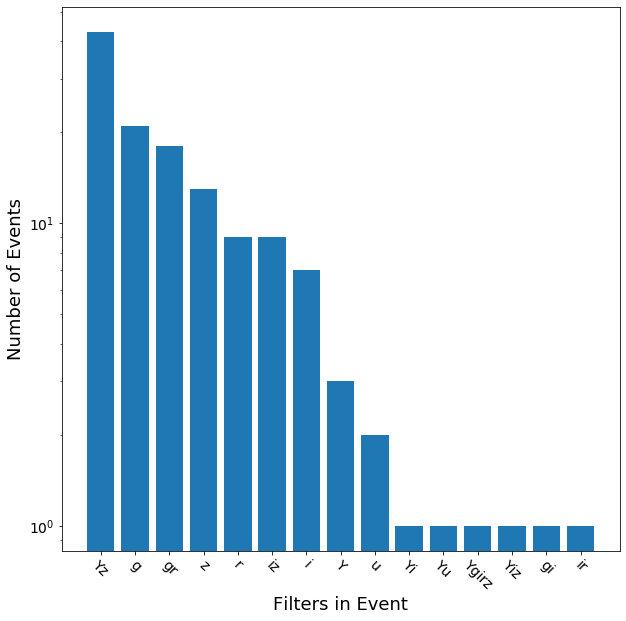

In [11]:
filters_in_event_hist = filters_in_event.value_counts()

fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(filters_in_event_hist.index, filters_in_event_hist)
ax.set_yscale("log")
ax.set_xlabel("Filters in Event", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=14)
ax.tick_params(axis='x', rotation=-45)
fig.savefig(f"{fig_dir}filters_in_event.png")
plt.show(fig)

In [12]:
def biggest_diff(chars):
    filters = ['u', 'g', 'r', 'i', 'z', 'Y']
    vals = np.arange(len(filters))
    f_dict = dict(zip(filters, vals))
    x = np.array([f_dict[k] for k in list(set(chars))])
    result = x.max() - x.min()
    return result

filter_diffs = results_df["filters"].apply(biggest_diff)

In [13]:
len(filter_diffs.loc[filter_diffs > 1])

5

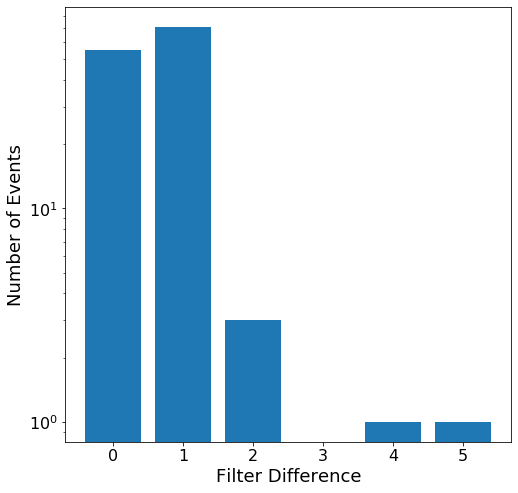

In [14]:
filter_diffs_hist = filter_diffs.value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(filter_diffs_hist.index, filter_diffs_hist)
ax.set_yscale("log")
ax.set_xlabel("Filter Difference", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}filter_difference_hist.png")
plt.show(fig)

In [15]:
filter_seq_count = results_df.groupby(by="filters").t_start.agg("count")

mask_two_sample_results = results_df["n_bright"] > 1
many_bright_ids = results_df.loc[results_df["n_bright"] > 9].index

two_sample_ids = results_df.loc[mask_two_sample_results].index
mask_two_sample = background_df["objectid"].isin(two_sample_ids)

achromatic_ids = results_df.loc[results_df["achromatic"]].index
mult2_ids = results_df.loc[results_df["multiplicity_2"]].index
n_achromatic = len(achromatic_ids)

mask_achromatic = background_df["objectid"].isin(achromatic_ids)
mask_bright = background_df["cluster_label"] == 0
mask_mult2 = background_df["objectid"].isin(mult2_ids)

bright_lc = background_df.loc[mask_bright & mask_two_sample]
bright_achromatic_lc = background_df.loc[mask_achromatic & mask_bright]
bright_achromatic_mult2_lc = background_df.loc[mask_achromatic & mask_bright & mask_mult2]

flux_double = -2.5 * np.log10(2)

dmag_bins = np.linspace(-2.5, 0, num=26)
bright_achromatic = background_df.loc[mask_achromatic & mask_bright]

mean_err = bright_achromatic["magerr_auto"].mean()
sigma_err = bright_achromatic["magerr_auto"].std()

achromatic_results = results_df.loc[results_df["achromatic"]]
achromatic_mult2_results = results_df.loc[results_df["achromatic"] & results_df["multiplicity_2"]]

n_distribution = results_df.loc[mask_two_sample_results].groupby(by="n_bright").filters.agg("count")
n_achromatic_distribution = achromatic_results.groupby(by="n_bright").filters.agg("count")
n_achromatic_mult2_distribution = achromatic_mult2_results.groupby(by="n_bright").filters.agg("count")

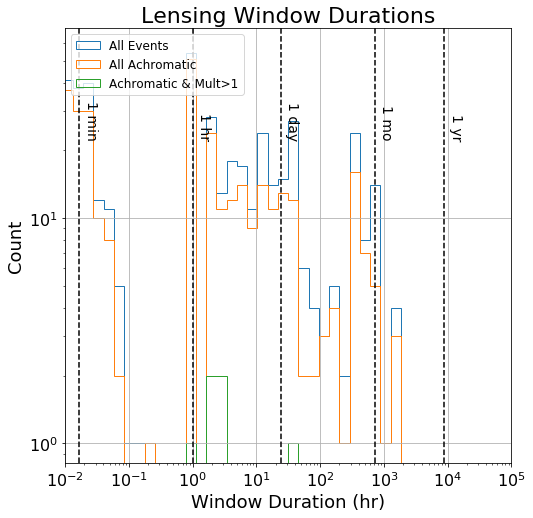

In [35]:
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.hr).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
bins = np.geomspace(results_df["delta_t"].min(), results_df["delta_t"].max() + 1, num=40)

fig, ax = plt.subplots(figsize=(8, 8))
results_df.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, ylabelsize=16, 
                label="All Events", histtype="step")

achromatic_results.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, 
                        ylabelsize=16, label="All Achromatic", histtype="step")

achromatic_mult2_results.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, 
                              ylabelsize=16,  label="Achromatic & Mult>1",  histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xlim((1e-2, 1e5))
ax.legend(loc="upper left", fontsize=12)
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.75)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_durations.png")
plt.close(fig)

In [36]:
len(results_df), sum(results_df["achromatic"]), sum(results_df["multiplicity_2"])

(641, 499, 30)

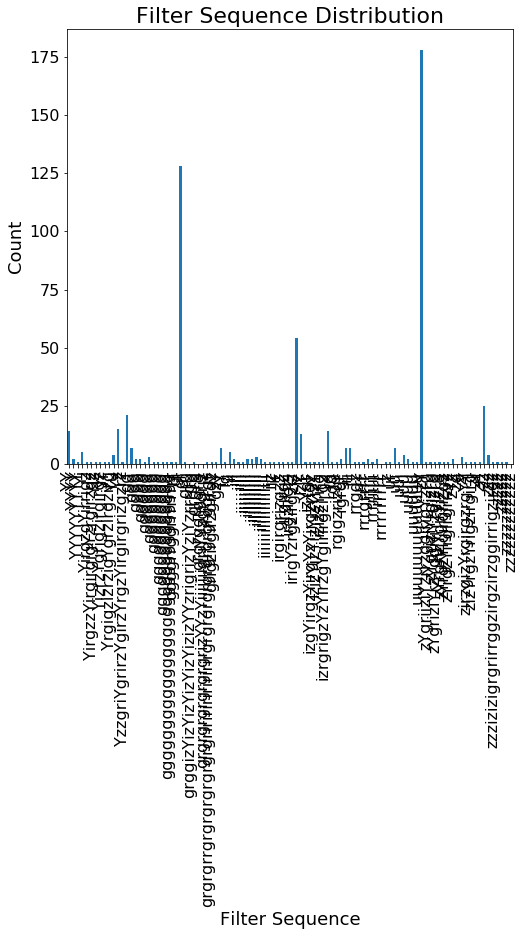

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
filter_seq_count.plot.bar(ax=ax)
ax.set_xlabel("Filter Sequence", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Filter Sequence Distribution", fontsize=22)
ax.tick_params(labelsize=16)
# ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, ha="right")
# ax.grid(visible=True)
plt.show(fig)
# fig.savefig(f"{fig_dir}filter_category_bar.png")
plt.close(fig)

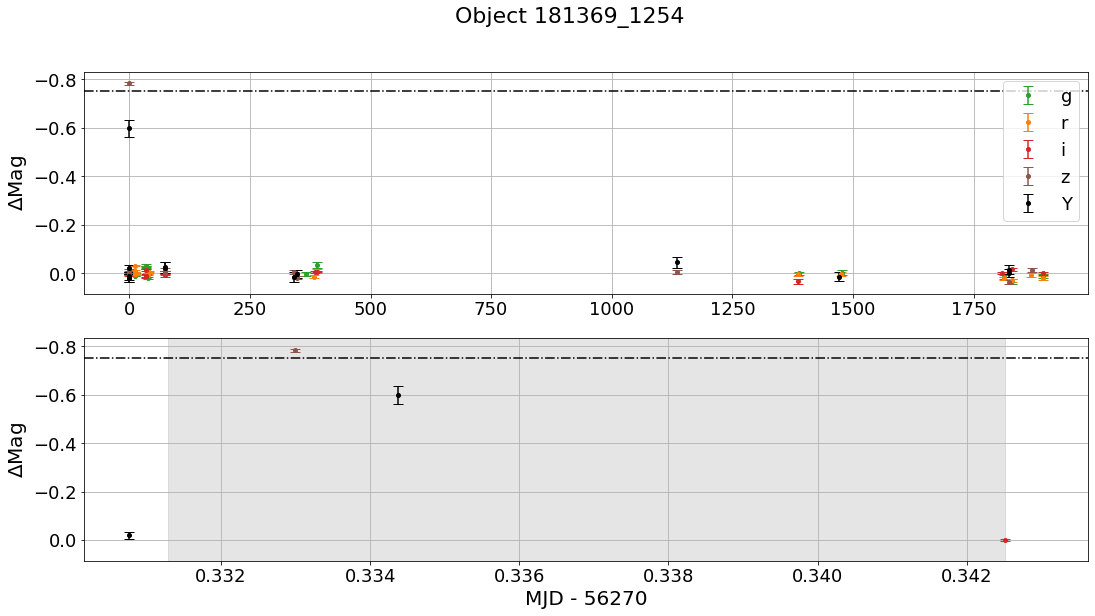

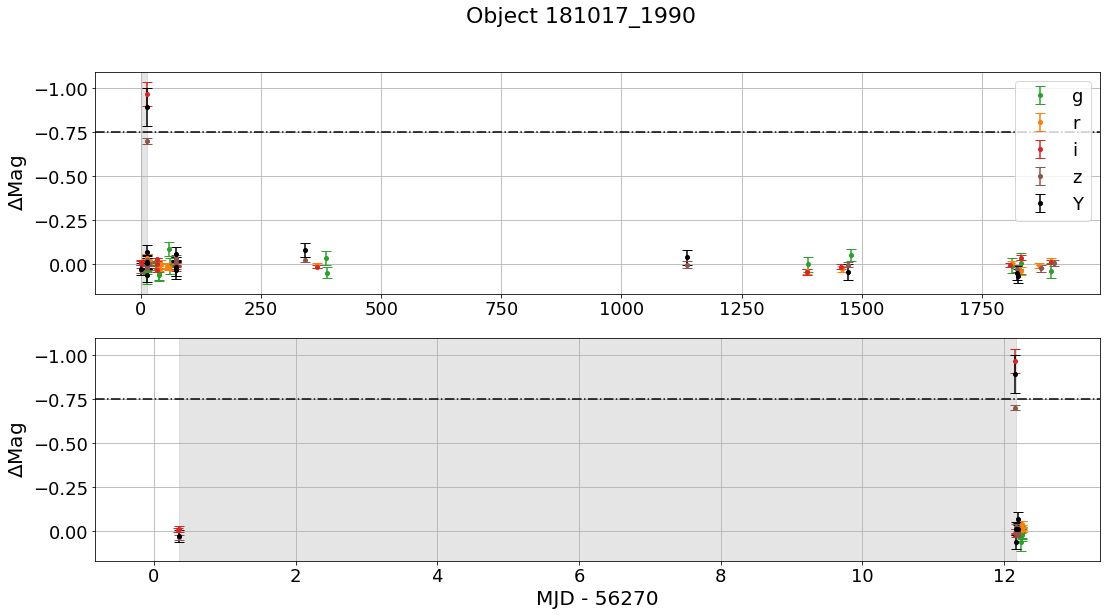

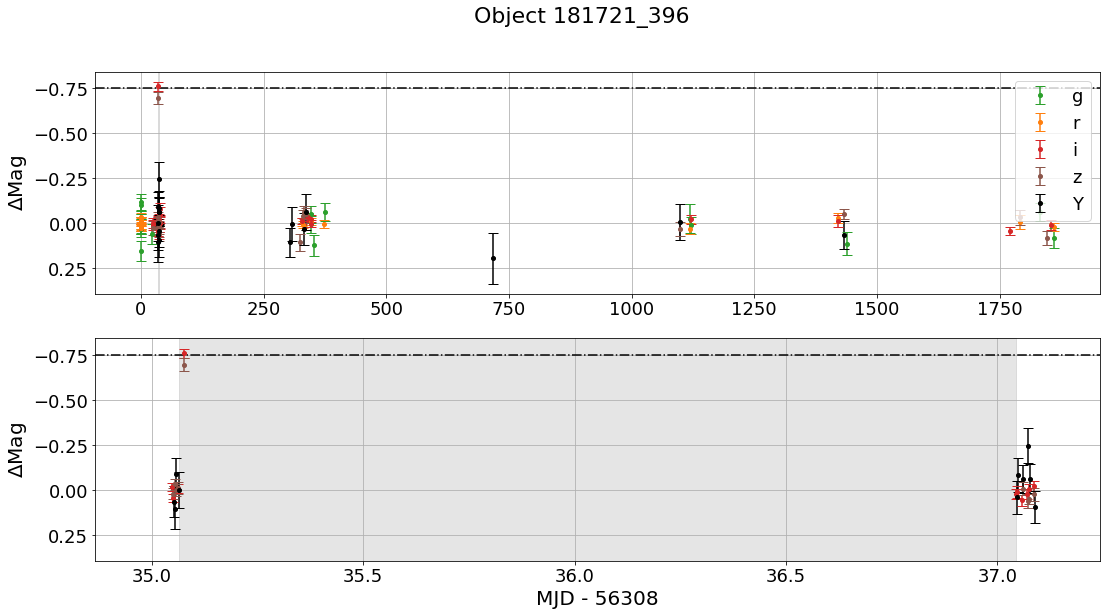

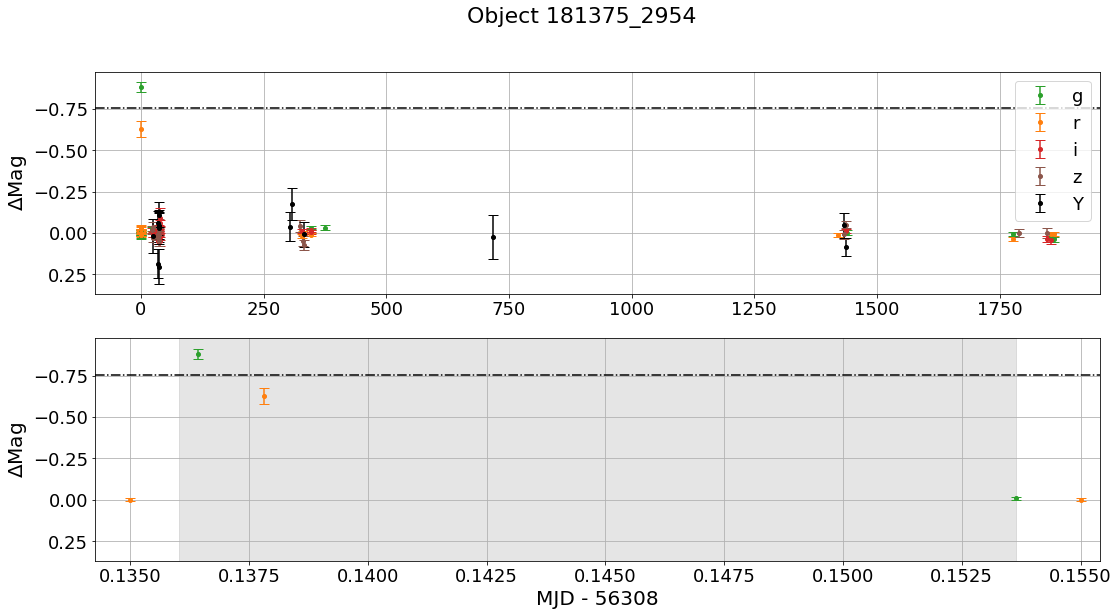

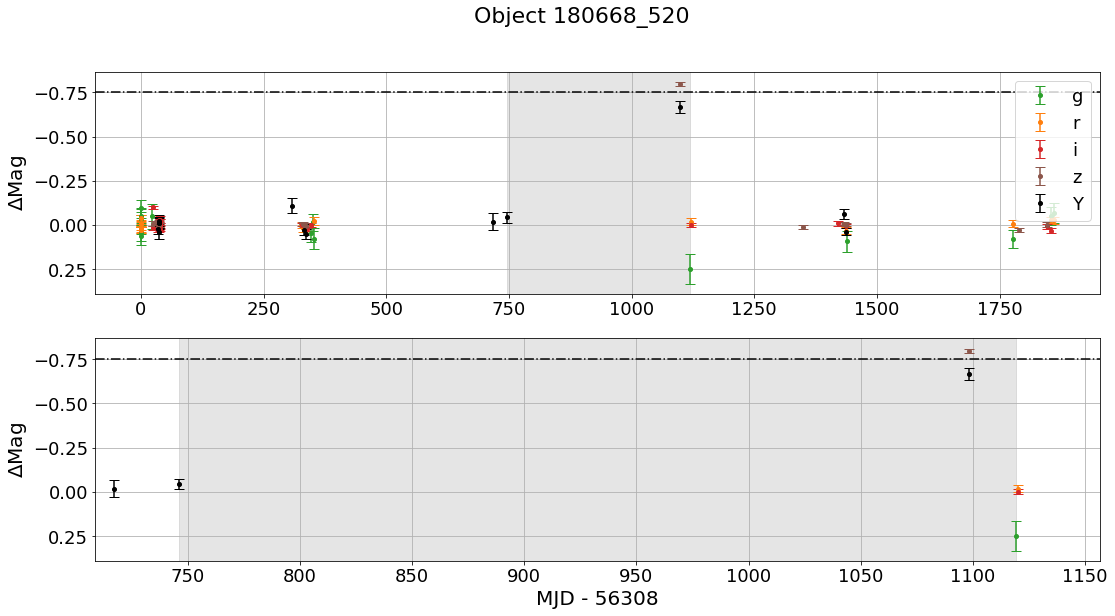

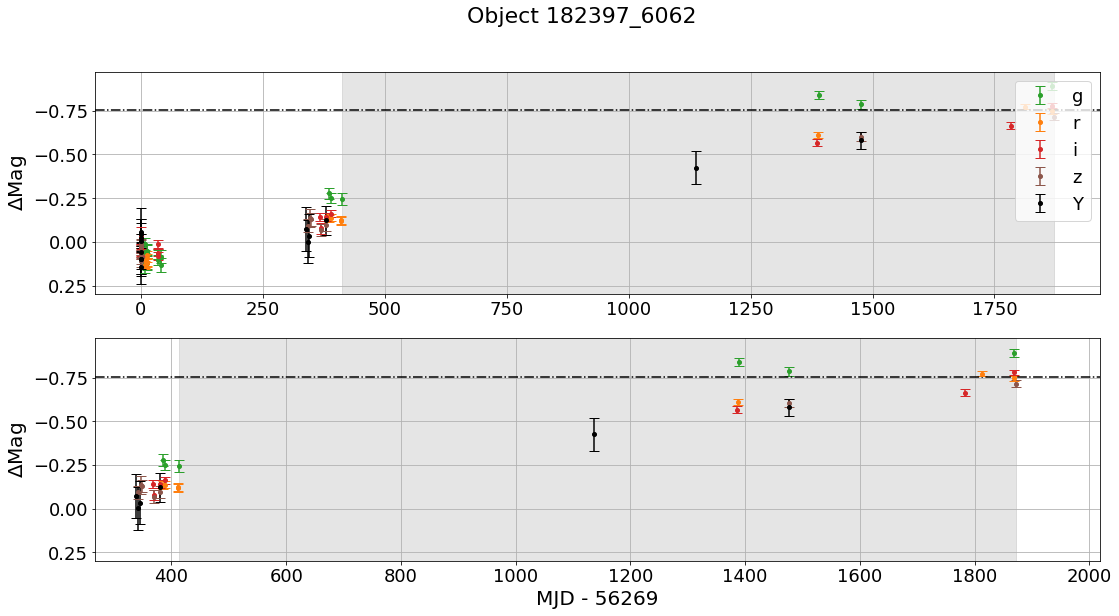

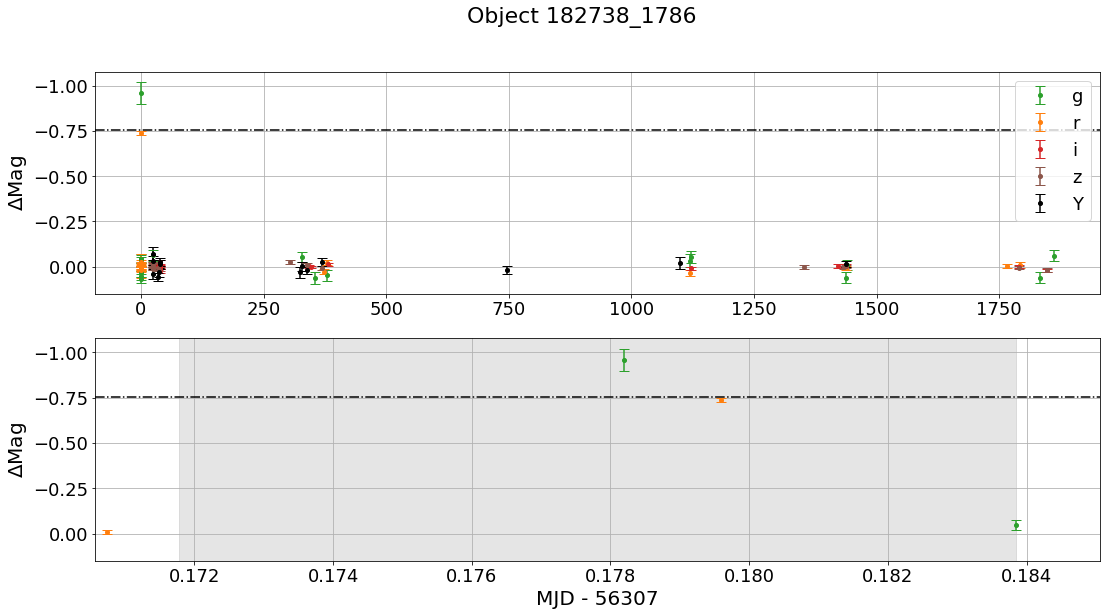

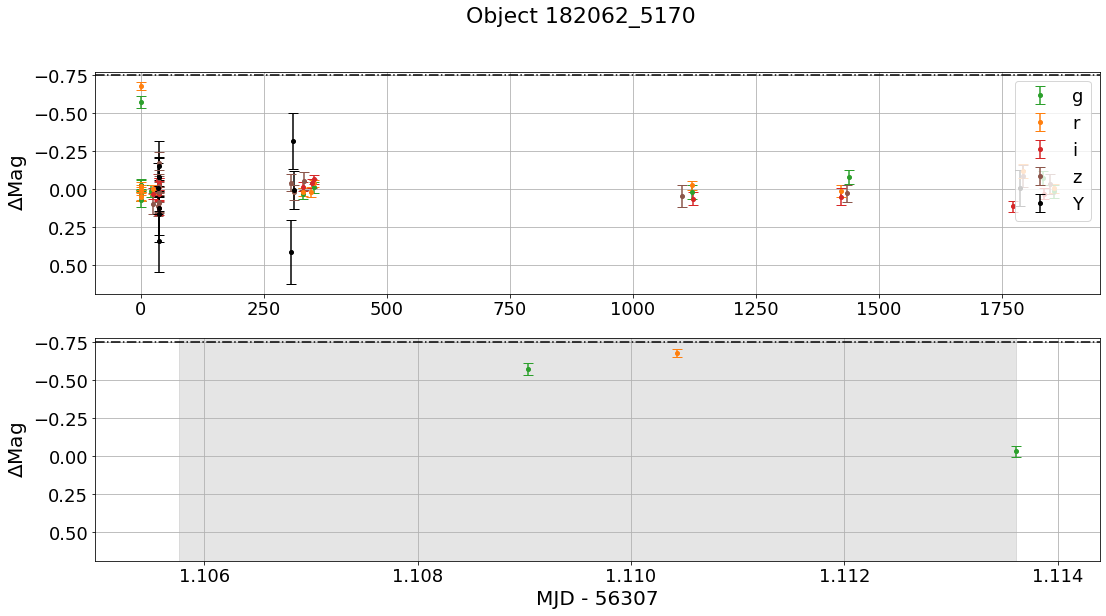

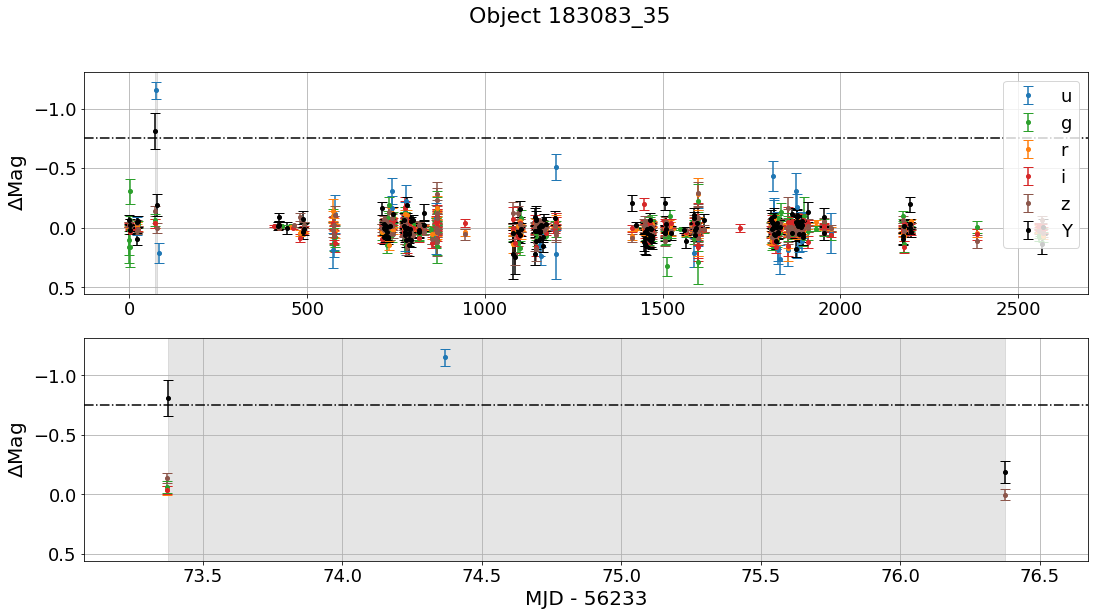

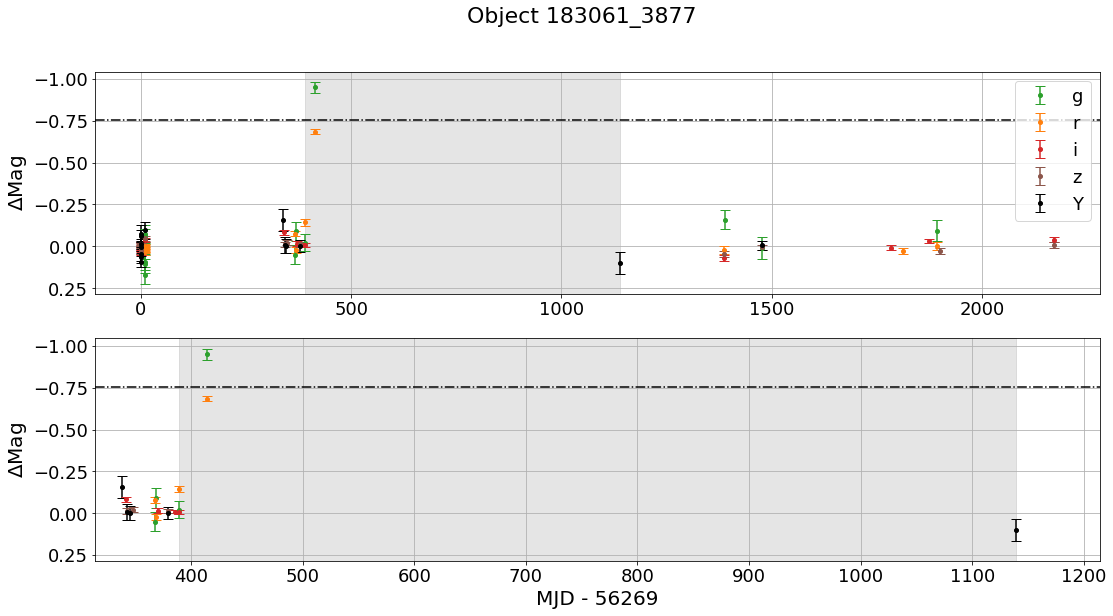

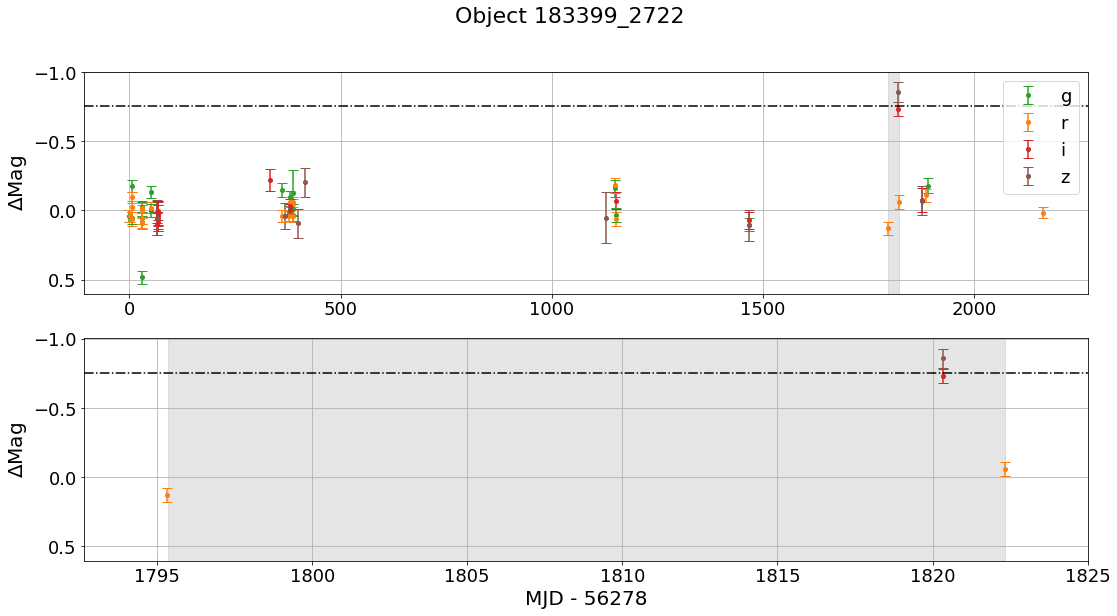

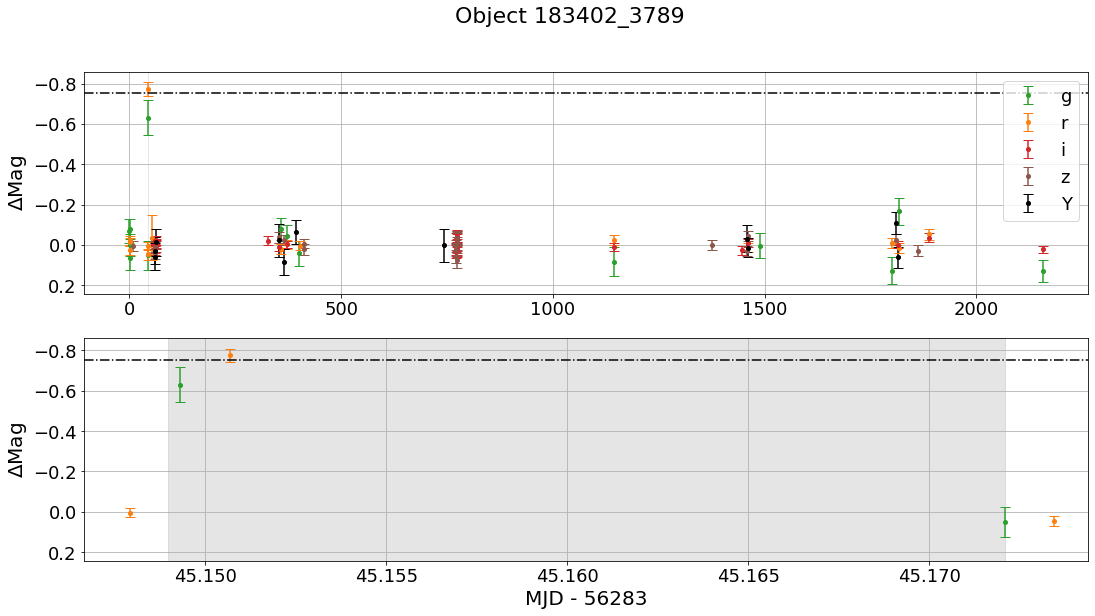

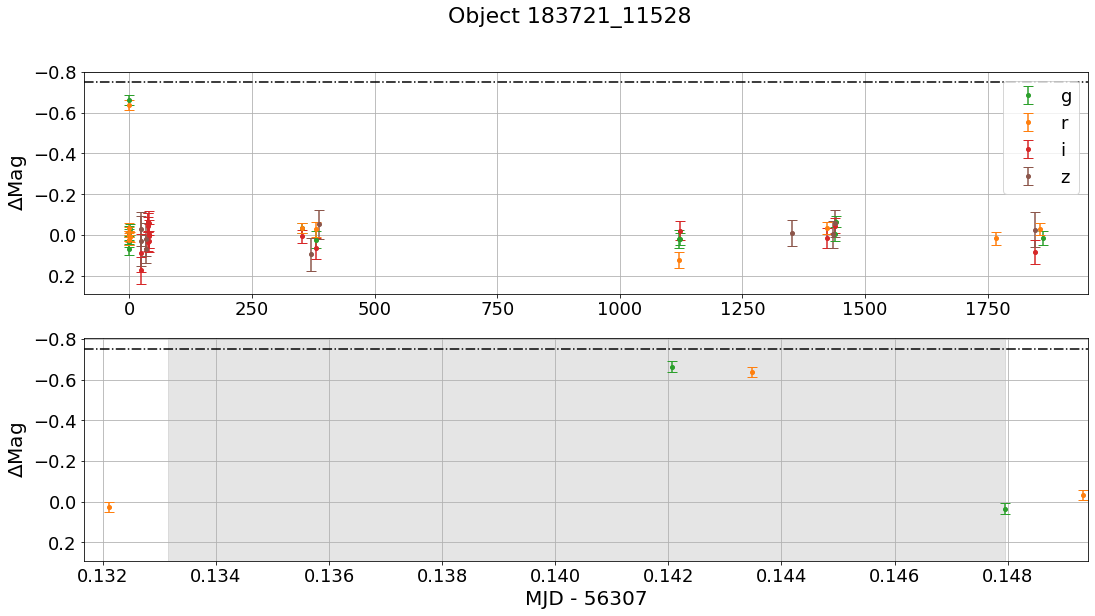

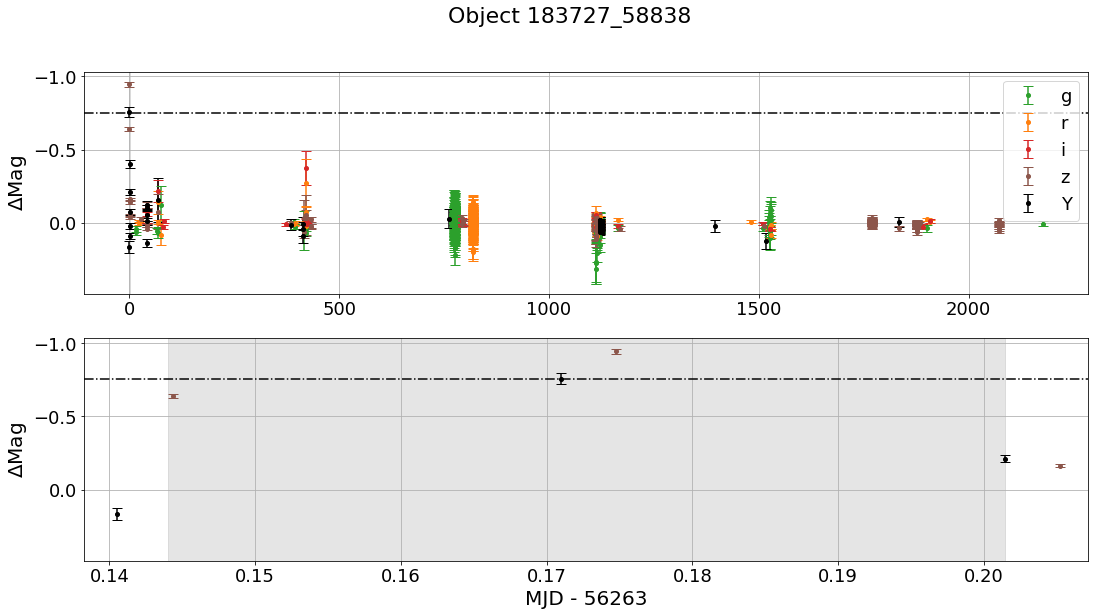

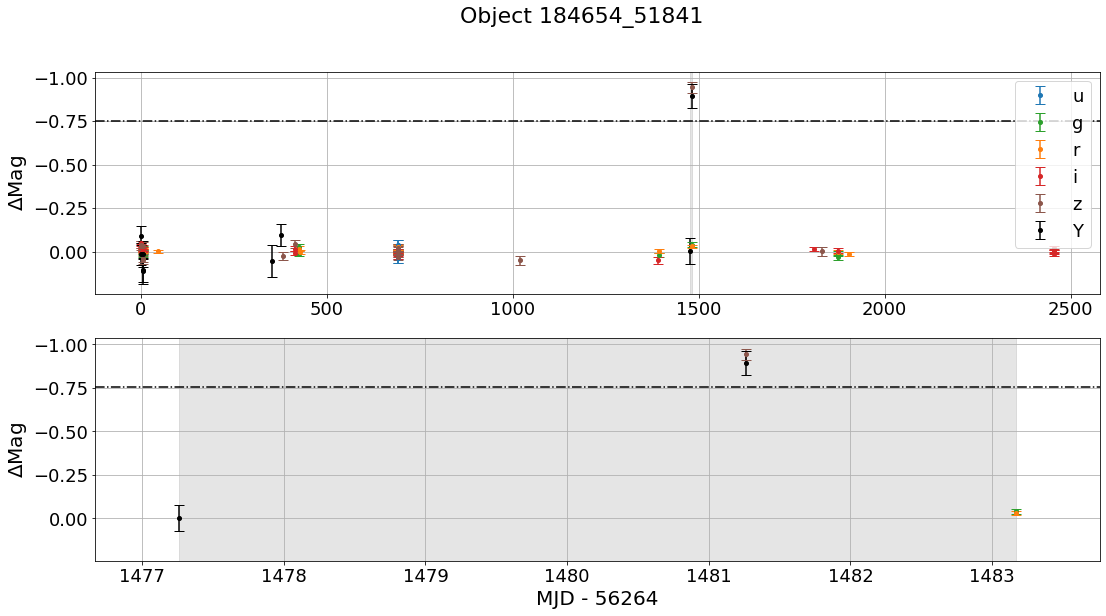

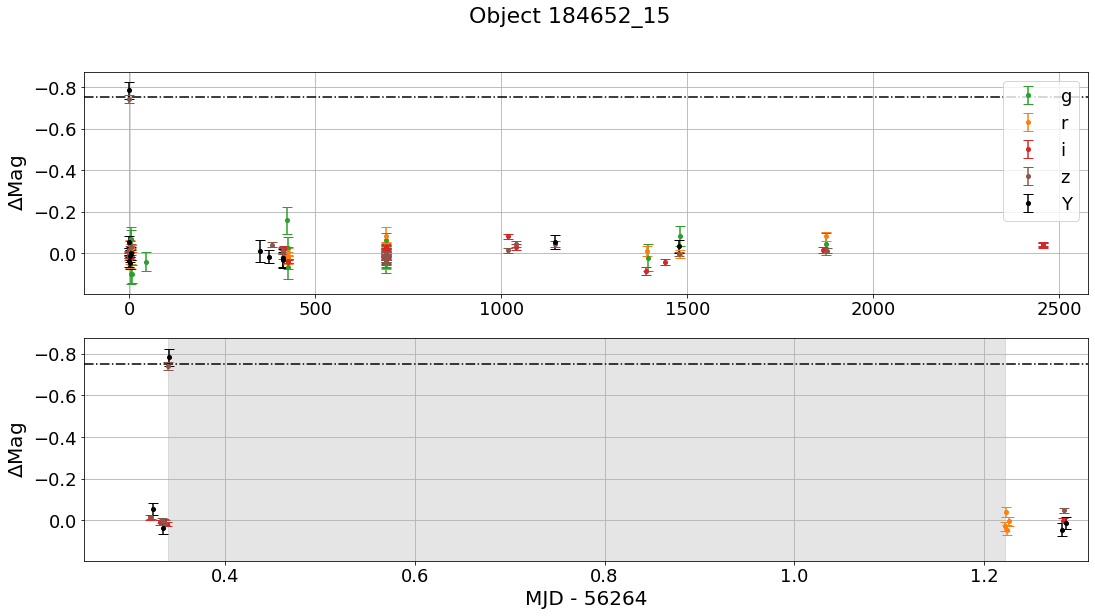

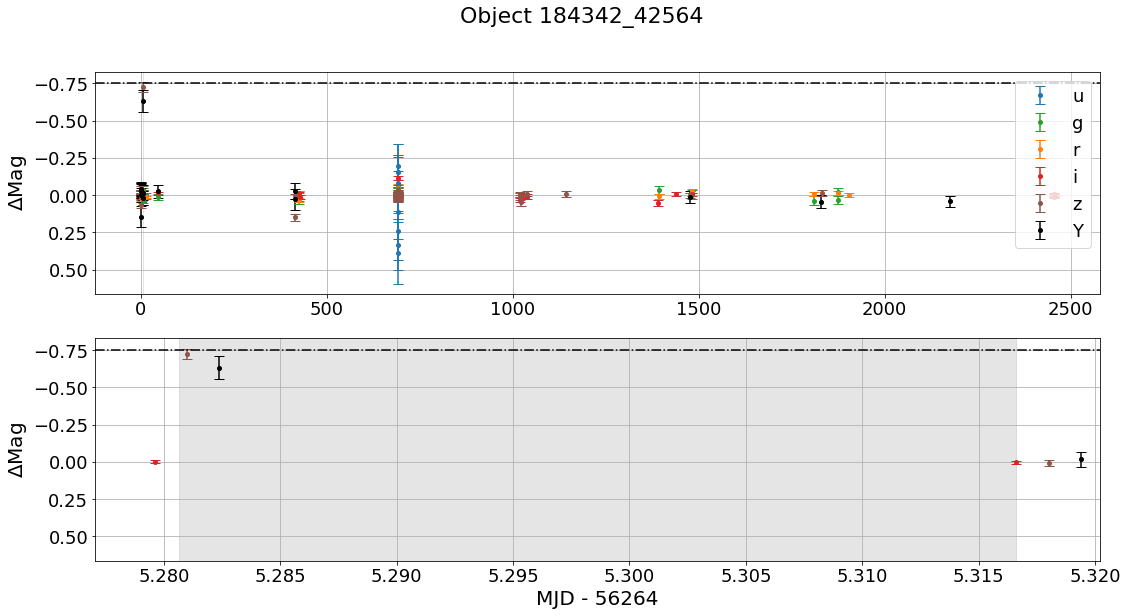

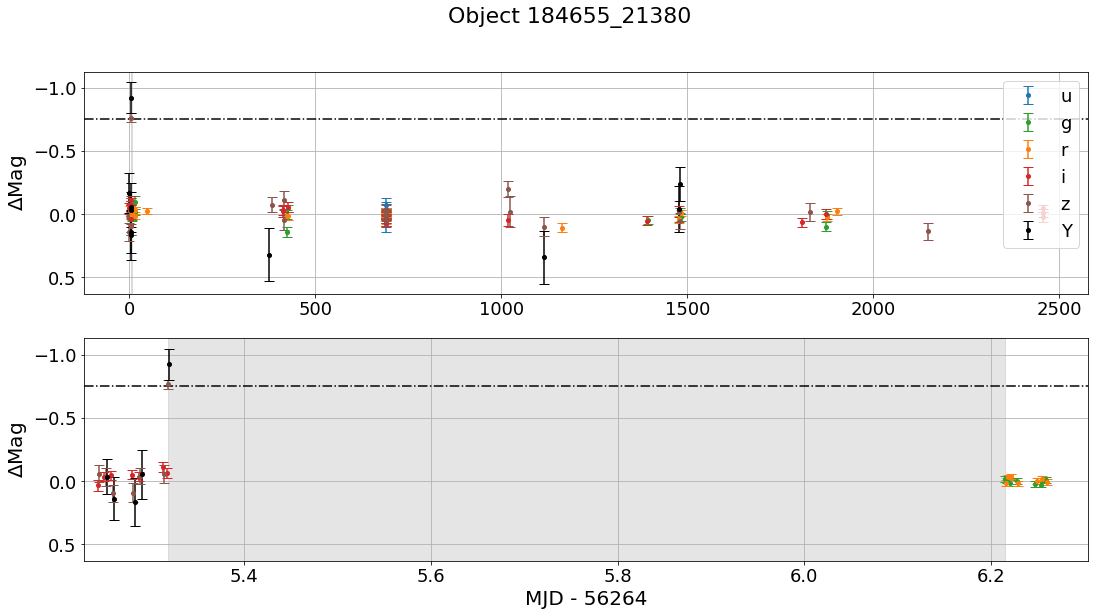

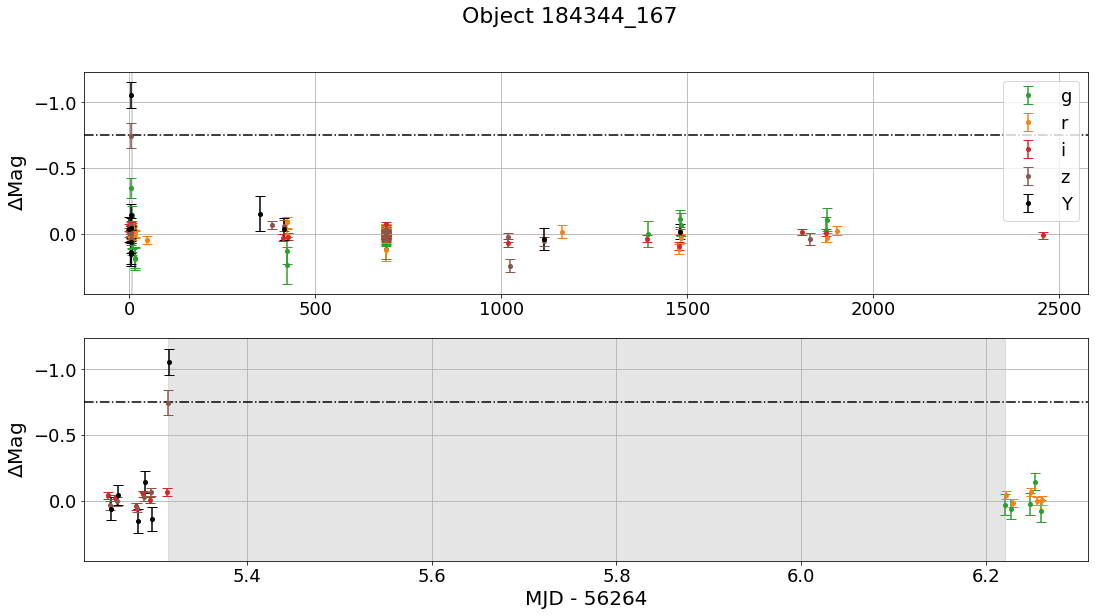

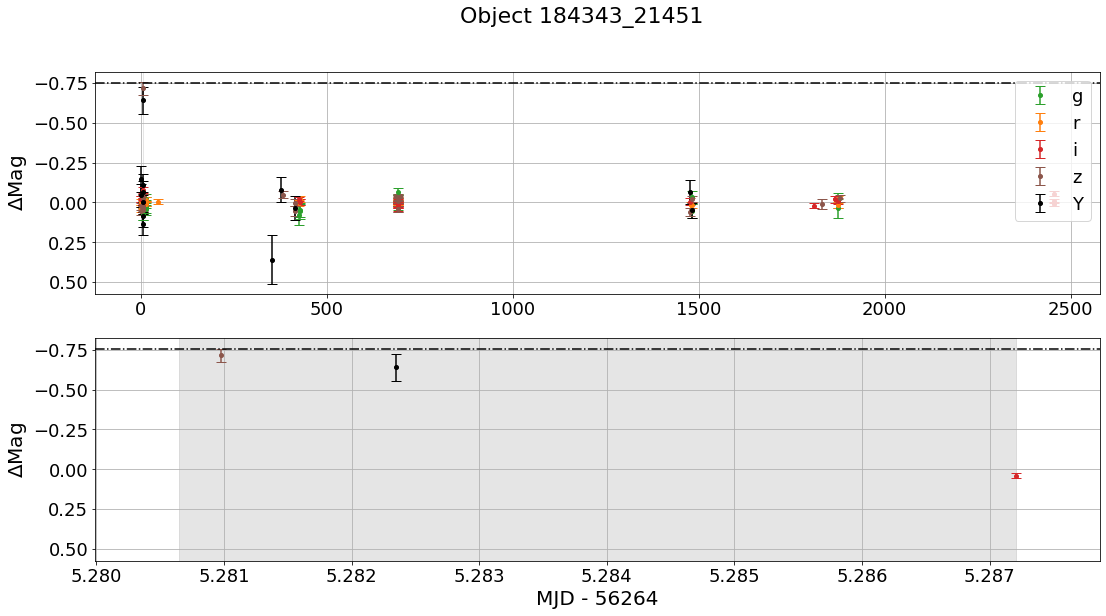

In [16]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown", 'k'])
filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])

for oid in achromatic_ids[:20]:
    fig, axes = plt.subplots(2, 1, figsize=(18, 9))
    row = results_df.loc[oid]
    ev_start, ev_end = row["t_start"], row["t_end"]
    m_id = lc_df["objectid"] == oid

    if np.isnan(ev_start):
        ev_start = lc_df.loc[m_id, "mjd"].min()
    if np.isnan(ev_end):
        ev_end = lc_df.loc[m_id, "mjd"].max()

    t_delta = ev_end - ev_start
    min_mjd = int(lc_df.loc[m_id, "mjd"].min())

    for f, c in zip(filters, colors):
        m_f = lc_df["filter"] == f
        lc_full = lc_df.loc[m_id & m_f]

        if len(lc_full) > 0:
            axes[0].errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None", label=f)
            axes[1].errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None")

    for ax in axes:
        ax.set_ylabel(r'$\Delta$Mag', fontsize=20)
        ax.tick_params(labelsize=18)
        ax.invert_yaxis()
        ax.grid(visible=True)
        barlims = (ev_start - min_mjd, ev_end - min_mjd)
        ax.axvspan(barlims[0], barlims[1], alpha=0.2, color="tab:gray")
        ax.axhline(flux_double, color='k', linestyle="-.")
        
    legend = axes[0].legend(fontsize=18, loc="upper right")
    axes[1].set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    t_lims = ((ev_start - 0.1 * t_delta) - min_mjd, (ev_end + 0.1 * t_delta) - min_mjd)
    axes[1].set_xlim(t_lims)
    fig.suptitle(f"Object {oid}", fontsize=22)
    plt.show(fig)
    fig.savefig(f"{fig_dir}{oid}_lightcurve_baseline_subtracted.png")
    plt.close(fig)

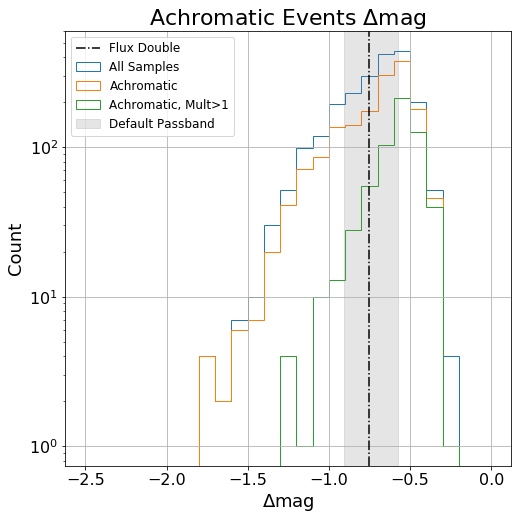

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
bright_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="All Samples")
bright_achromatic_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="Achromatic")
bright_achromatic_mult2_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="Achromatic, Mult>1")
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.axvspan(-2.5 * np.log10(2.3), -2.5 * np.log10(1.7), alpha=0.2, 
           color="tab:gray", label="Default Passband")
ax.axvline(-2.5 * np.log10(2), color='k', ls="-.", label="Flux Double")
ax.set_yscale("log")
ax.tick_params(labelsize=16)
ax.legend(loc="upper left", fontsize=12)
ax.set_title(r"Achromatic Events $\Delta$mag", fontsize=22)
plt.show(fig)
# fig.savefig(f"{fig_dir}achromatic_events_deltamag.png")
plt.close(fig)

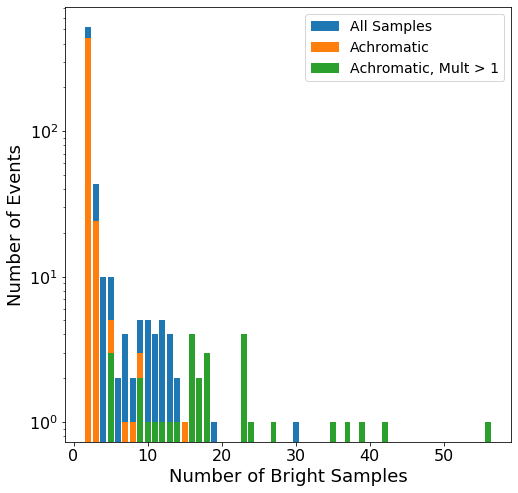

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(n_distribution.index, n_distribution, label="All Samples")
ax.bar(n_achromatic_distribution.index, n_achromatic_distribution, label="Achromatic")
ax.bar(n_achromatic_mult2_distribution.index, n_achromatic_mult2_distribution, label="Achromatic, Mult > 1")
ax.set_yscale("log")
ax.legend(loc="upper right", fontsize=14)
ax.set_xlabel("Number of Bright Samples", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=16)
plt.show(fig)

In [15]:
import importlib
importlib.reload(datalab_utils)

reduced_df = datalab_utils.cluster_label_dataframe(lc_df.sort_values(by=["batch", "objectid", "mjd"]), 
                                                   bandwidth=2.5 * np.log10(2) / 4)

In [16]:
filtered_df = reduced_df.groupby("objectid").filter(datalab_utils.lens_filter)

In [17]:
filtered_results = datalab_utils.make_lensing_dataframe(filtered_df)

In [18]:
len(filtered_results)

351

In [19]:
m = filtered_results["filters"].apply(lambda x: len(set(x)) > 1)
len(filtered_results.loc[m])

113

In [14]:
def hubble_z(omega_r, omega_m, omega_k, omega_lam, z):
    result = np.sqrt(omega_m * (1+z)**3 + omega_r * (1+z)**4 + omega_k * (1 + z)**2 + omega_lam)
    return result

def omega_m_z(omega_m0, omega_k, omega_lam, omega_r, z):
    result = omega_m0 * (1 + z)**3 / hubble_z(omega_r, omega_m0, omega_k, omega_lam, z)**2
    return result

In [23]:
z = np.linspace(0, 10, 1001)
dz = z[1] - z[0]
omega_m = 0.3
omega_lam = 0.7
omega_k = 0
omega_r = 0
w = -1
gam = 0.55 + (1 + w)
little_y = (omega_m_z(omega_m, omega_k, omega_lam, omega_r, z))**gam / (1 + z)
big_y = np.exp(-np.cumsum(little_y * dz))

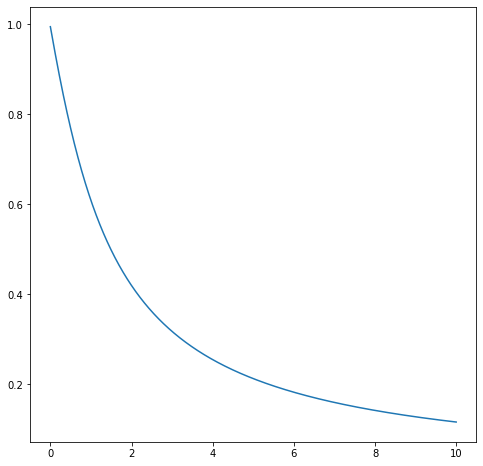

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(z, big_y)
plt.show(fig)